In [1]:
import numpy as np

import cycler
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

import pygam
from sklearn.linear_model import RidgeCV
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from LookaheadCQR.lookahead.models.lookahead import Lookahead
import LookaheadCQR.lookahead.models.uncertainty as uncert
import LookaheadCQR.lookahead.models.prediction as pred
import LookaheadCQR.lookahead.models.propensity as prop
from LookaheadCQR.cqr_lookahead.uncertainty import CQR

%matplotlib inline
np.set_printoptions(precision=3)

## Loading the diabetes dataset

In [2]:
#load data
data_bunch = load_diabetes()
x,y0 = data = load_diabetes(return_X_y=True)
y0 = -y0
y0 = (y0-np.min(y0))/(np.max(y0)-np.min(y0))
scaler = StandardScaler()
scaler.fit(x)
scaler.transform(x, copy=False)
n = x.shape[0]
d = x.shape[1]

## Defining the groundtruth model.
Here we choose linearGAM model as f*

In [3]:
lams = np.random.rand(100, x.shape[1])
lams = lams * 6 - 3
lams = np.exp(lams)
fstar = pygam.LinearGAM(n_splines=12, max_iter=100).gridsearch(x, y0, lam=lams)
y = fstar.predict(x)
mse_star = np.mean(np.square(y-y0))
mae_star = np.mean(np.abs(y-y0))
print("[f*] mse(y,y0):", mse_star)
print("[f*] mae(y,y0):", mae_star)

100% (100 of 100) |######################| Elapsed Time: 0:00:32 Time:  0:00:32


[f*] mse(y,y0): 0.024703304804829726
[f*] mae(y,y0): 0.12617516023273548


<Figure size 432x288 with 0 Axes>

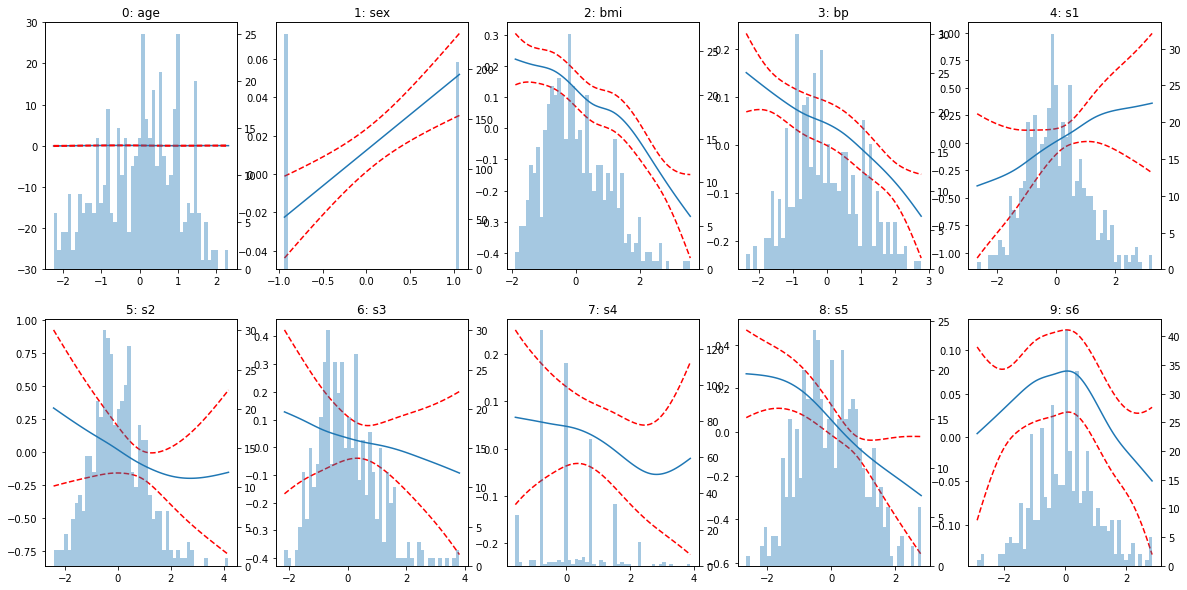

In [4]:
titles = data_bunch.feature_names
titles_idx = [str(i)+': '+titles[i] for i in range(len(titles))]

plt.figure()
fig, axs = plt.subplots(2,5,figsize=(20, 10))
for i, ax in enumerate(axs.flatten()[:x.shape[1]]):
    XX = fstar.generate_X_grid(term=i)
    ax.plot(XX[:, i], fstar.partial_dependence(term=i, X=XX))
    ax2 = ax.twinx()
    ax2.hist(x[:, i], alpha=.4, bins=50) #, density=True)
    ax.plot(XX[:, i], fstar.partial_dependence(term=i, X=XX,   width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles_idx[i])
plt.show()

## Generating the train-test splits

In [5]:
# split data
seed = 1
trn_sz = 0.75 # working-set relative size
active = np.arange(n) # No sub-sampling

x_active = x[active,:]
# y_active = y[active]
y_active = y0[active]
n_active = y_active.shape[0]

x_trn, x_tst, y_trn, y_tst, idx_trn, idx_tst = train_test_split(x_active, y_active, active, test_size=1-trn_sz, random_state=seed)
n_trn, n_tst = (x_trn.shape[0], x_tst.shape[0])
print('n:', n, ', n_active:', n_active, ", n_trn:", n_trn, ", n_tst:", n_tst)

xs = [x_trn, x_tst, x_active, x]
ys = [y_trn, y_tst, y_active, y]

n: 442 , n_active: 442 , n_trn: 331 , n_tst: 111


## Setting the hyperparamters of the look ahead model

In [6]:
# Step Size
eta = 5.

# L2 regularization coefficients
alphas = np.hstack([1e-5, 2.**np.arange(-8,6,1)])
alphas_sub = [0, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0]

# Lookahead regularization coefficient
lams = np.hstack([1e-5, 2.**np.arange(-7,-1,1)]) #lookahead penalty coefficients

# Setting features that can by altered using mask
# Features - 2 and 4 are the only non-immutable features
mask = np.zeros(d)
mask[[2,4]] = 1

# Degree of the polynomial to be used for regression
deg = 2

# Number of cycles to train
num_cycles = 10

# Confidence Intervals
z_score = 1.65 # for confiednce intervals (1.28-90%, 1.65=95%)

""" Hyperparameters for Prediction Model"""
# L2 - regularization coeffs
alpha_f = 0.5
# Regularization type (L1/L2)
reg_type = 'l2'
# Learning rate
lr_f = 0.05
# Number of iterations
num_iter_init = 1000 #for initial f
num_iter_f = 100 #for training f in cycles
num_iter_base = num_iter_init + num_iter_f*num_cycles

""" Hyperparameters for Uncertainty Model"""
# Number of bootstrapped models
num_gs = 20
# Learning rate
lr_g = 0.05
# Number of iterations
num_iter_g = 500 #for training g in cycles

## Training a baseline model and displaying the weights learnt and the result

t: 0
[f] mse: 0.0279, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0293
[f] improve*: 0.030



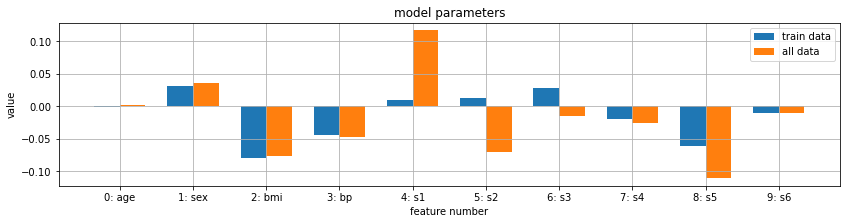

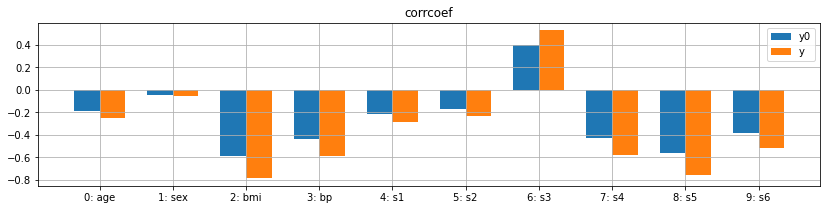

baseline: (skl)
		trn	tst	actv	all
mse	0.0279	0.0285	0.0281	0.0024
mae	0.1375	0.1317	0.1361	0.0385

baseline: (ours)
base:	trn	tst	actv	all
mse	0.0279	0.0285	0.0281	0.0024
mae	0.1375	0.1317	0.1361	0.0385
imprv	0.0296	0.0448	0.0334	0.0334
imprt	0.5589	0.6126	0.5724	1.0000

best reg coef: 32.0 , idx: 14


In [7]:
# baselines
verbose = True

# scikitlearn - to get optimal regularization coefficient via CV)
f_base_skl = RidgeCV(alphas=alphas, cv=None).fit(x_trn, y_trn)
w_base_skl = f_base_skl.coef_
best_alpha = float(f_base_skl.alpha_)
best_alpha_idx = int(np.where(alphas==best_alpha)[0])

# benchmark trained on all data
f_bench = RidgeCV(alphas=alphas, cv=None).fit(x, y)
w_bench = f_bench.coef_

# ours - for sanity check (vs SKL) and to get baseline improvement
f_base = pred.PredModel(d, reg_type=reg_type, alpha=best_alpha, lr=lr_f, num_iter_init=num_iter_base)
model_base = Lookahead(f_base, None, None, lam=0., eta=eta, mask=mask, ground_truth_model=fstar)
_, _ = model_base.train(x_trn, y_trn, num_cycles=0, random_state=seed, verbose=verbose)

plt.rcParams['figure.figsize'] = (14.0, 3.0)
barWidth = 0.35
plt.bar(np.arange(d)-barWidth/2,w_base_skl,alpha=1,width=barWidth)
plt.bar(np.arange(d)+barWidth/2,w_bench,alpha=1,width=barWidth)
plt.xticks(np.arange(d),titles_idx)
plt.title('model parameters')
plt.ylabel('value')
plt.xlabel('feature number')
plt.legend(['train data','all data'])
plt.grid()
plt.show()


cor_y0 = [np.corrcoef(x[:,i],y0)[0,1] for i in range(d)]
cor_y = [np.corrcoef(x[:,i],y)[0,1] for i in range(d)]
plt.bar(np.arange(d)-barWidth/2,cor_y0,width=barWidth)
plt.bar(np.arange(d)+barWidth/2,cor_y,width=barWidth)
plt.title('corrcoef')
plt.legend(['y0','y'])
plt.xticks(np.arange(d),titles_idx)
plt.grid()
plt.show()

perf_base_skl = {'mse':[], 'mae':[]}
for x_,y_ in zip(xs, ys):
    yhat_ = f_base_skl.predict(x_)
    perf_base_skl['mse'].append(np.mean(np.square(y_-yhat_)))
    perf_base_skl['mae'].append(np.mean(np.abs(y_-yhat_)))
print('baseline: (skl)')
print('\t\ttrn\ttst\tactv\tall')
print(('mse'+'\t{:.4f}'*4).format(*perf_base_skl['mse']))
print(('mae'+'\t{:.4f}'*4).format(*perf_base_skl['mae']))
print()

perf_base = {'mse':[], 'mae':[], 'improve':[], 'imprate':[]}
for x_,y_ in zip(xs, ys):
    perf_base['mse'].append(model_base.mse(x_,y_))
    perf_base['mae'].append(model_base.mae(x_,y_))
    perf_base['improve'].append(model_base.improve(x_,y_,eta,mask))
    perf_base['imprate'].append(model_base.improve_rate(x_,y_,eta,mask))
print('baseline: (ours)')
print('base:\ttrn\ttst\tactv\tall')
print(('mse'+'\t{:.4f}'*4).format(*perf_base['mse']))
print(('mae'+'\t{:.4f}'*4).format(*perf_base['mae']))
print(('imprv'+'\t{:.4f}'*4).format(*perf_base['improve']))
print(('imprt'+'\t{:.4f}'*4).format(*perf_base['imprate']))
print()

print('best reg coef:', best_alpha, ', idx:', best_alpha_idx)

## Training the lookahead model for different values of l2-regularizer coefficient

In [8]:
# train our model
verbose = True

#==TEMP==
# alphas_sub = [1e-7]
# lams = [0, 0.01, 0.05]
# num_cycles = 5
#========

all_models = []
all_mfs = []
all_mus = []
for alpha in alphas_sub:
    models = []
    mfs = []
    mus = []
    for lam_ in lams:
        print('-- alpha:', alpha, ', lam_:', lam_, '--')
        f = pred.PredModel(d, reg_type=reg_type, alpha=alpha, lr=lr_f, num_iter=num_iter_f, num_iter_init=num_iter_init)
        u = uncert.BootstrapResid(d, f, alpha=0., num_gs=num_gs, z_score=z_score, lr=lr_g, num_iter=num_iter_g)
        h = prop.PropModel(random_state=seed)

        model = Lookahead(f, u, h, lam=lam_, eta=eta, mask=mask, ground_truth_model=fstar)
        mf, mu = model.train(x_trn, y_trn, num_cycles=num_cycles, random_state=seed, verbose=verbose)

        models.append(model)
        mfs.append(mf)
        mus.append(mu)
    all_models.append(models)
    all_mfs.append(mfs)
    all_mus.append(mus)


all_mus = np.asarray(all_mus)
all_mfs = np.asarray(all_mfs)

-- alpha: 0 , lam_: 1e-05 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0278
[f] improve*: 0.062

t: 1
[h] n_eff: 5.21, w_sum: 910.72
[u] loss: 0.0182, norm_reg: 0.0000, obj: 0.0182
[u] size: 0.402, contain*: 0.946
[f] mse: 0.0277, la_reg: 0.1769, norm_reg: 0.0000, obj: 0.0278
[f] improve*: 0.064

t: 2
[h] n_eff: 4.99, w_sum: 934.05
[u] loss: 0.0173, norm_reg: 0.0000, obj: 0.0173
[u] size: 0.414, contain*: 0.946
[f] mse: 0.0277, la_reg: 0.1819, norm_reg: 0.0000, obj: 0.0277
[f] improve*: 0.066

t: 3
[h] n_eff: 4.84, w_sum: 942.86
[u] loss: 0.0165, norm_reg: 0.0000, obj: 0.0165
[u] size: 0.423, contain*: 0.946
[f] mse: 0.0277, la_reg: 0.1855, norm_reg: 0.0000, obj: 0.0277
[f] improve*: 0.067

t: 4
[h] n_eff: 4.73, w_sum: 940.69
[u] loss: 0.0160, norm_reg: 0.0000, obj: 0.0160
[u] size: 0.430, contain*: 0.946
[f] mse: 0.0277, la_reg: 0.1880, norm_reg: 0.0000, obj: 0.0277
[f] improve*: 0.069

t: 5
[h] n_eff: 4.66, w_sum: 930.73
[u] loss: 0.0156, norm_reg: 0.0000, obj: 0

[f] mse: 0.0279, la_reg: 0.1045, norm_reg: 0.0000, obj: 0.0311
[f] improve*: 0.140

t: 10
[h] n_eff: 11.45, w_sum: 48.55
[u] loss: 0.0327, norm_reg: 0.0000, obj: 0.0327
[u] size: 0.297, contain*: 0.801
[f] mse: 0.0279, la_reg: 0.1033, norm_reg: 0.0000, obj: 0.0311
[f] improve*: 0.141

-- alpha: 0 , lam_: 0.0625 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0278
[f] improve*: 0.062

t: 1
[h] n_eff: 5.21, w_sum: 910.72
[u] loss: 0.0182, norm_reg: 0.0000, obj: 0.0182
[u] size: 0.402, contain*: 0.946
[f] mse: 0.0279, la_reg: 0.1629, norm_reg: 0.0000, obj: 0.0381
[f] improve*: 0.097

t: 2
[h] n_eff: 4.38, w_sum: 421.24
[u] loss: 0.0164, norm_reg: 0.0000, obj: 0.0164
[u] size: 0.425, contain*: 0.949
[f] mse: 0.0280, la_reg: 0.1543, norm_reg: 0.0000, obj: 0.0376
[f] improve*: 0.127

t: 3
[h] n_eff: 7.26, w_sum: 92.55
[u] loss: 0.0266, norm_reg: 0.0000, obj: 0.0266
[u] size: 0.332, contain*: 0.894
[f] mse: 0.0280, la_reg: 0.1118, norm_reg: 0.0000, obj: 0.0349
[f] improve*: 

[h] n_eff: 4.56, w_sum: 896.05
[u] loss: 0.0152, norm_reg: 0.0000, obj: 0.0152
[u] size: 0.441, contain*: 0.952
[f] mse: 0.0277, la_reg: 0.1917, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.073

t: 9
[h] n_eff: 4.53, w_sum: 878.93
[u] loss: 0.0150, norm_reg: 0.0000, obj: 0.0150
[u] size: 0.442, contain*: 0.952
[f] mse: 0.0277, la_reg: 0.1920, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.074

t: 10
[h] n_eff: 4.52, w_sum: 861.64
[u] loss: 0.0150, norm_reg: 0.0000, obj: 0.0150
[u] size: 0.443, contain*: 0.955
[f] mse: 0.0277, la_reg: 0.1921, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.074

-- alpha: 0.125 , lam_: 0.0078125 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.061

t: 1
[h] n_eff: 5.28, w_sum: 901.60
[u] loss: 0.0186, norm_reg: 0.0000, obj: 0.0186
[u] size: 0.398, contain*: 0.949
[f] mse: 0.0277, la_reg: 0.1734, norm_reg: 0.0001, obj: 0.0291
[f] improve*: 0.068

t: 2
[h] n_eff: 4.69, w_sum: 943.82
[u] loss: 0.0160, norm_reg: 0.0000, ob

[f] mse: 0.0280, la_reg: 0.0954, norm_reg: 0.0002, obj: 0.0340
[f] improve*: 0.154

t: 7
[h] n_eff: 15.28, w_sum: 32.50
[u] loss: 0.0364, norm_reg: 0.0000, obj: 0.0364
[u] size: 0.284, contain*: 0.770
[f] mse: 0.0280, la_reg: 0.0942, norm_reg: 0.0002, obj: 0.0339
[f] improve*: 0.156

t: 8
[h] n_eff: 16.07, w_sum: 30.65
[u] loss: 0.0369, norm_reg: 0.0000, obj: 0.0369
[u] size: 0.283, contain*: 0.764
[f] mse: 0.0280, la_reg: 0.0934, norm_reg: 0.0002, obj: 0.0339
[f] improve*: 0.158

t: 9
[h] n_eff: 16.63, w_sum: 29.47
[u] loss: 0.0373, norm_reg: 0.0000, obj: 0.0373
[u] size: 0.281, contain*: 0.761
[f] mse: 0.0280, la_reg: 0.0929, norm_reg: 0.0002, obj: 0.0338
[f] improve*: 0.159

t: 10
[h] n_eff: 17.03, w_sum: 28.69
[u] loss: 0.0375, norm_reg: 0.0000, obj: 0.0375
[u] size: 0.281, contain*: 0.758
[f] mse: 0.0280, la_reg: 0.0926, norm_reg: 0.0002, obj: 0.0338
[f] improve*: 0.159

-- alpha: 0.125 , lam_: 0.125 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0278
[f] improv

[h] n_eff: 4.43, w_sum: 680.13
[u] loss: 0.0149, norm_reg: 0.0000, obj: 0.0149
[u] size: 0.442, contain*: 0.955
[f] mse: 0.0277, la_reg: 0.1856, norm_reg: 0.0001, obj: 0.0292
[f] improve*: 0.086

t: 6
[h] n_eff: 4.50, w_sum: 571.08
[u] loss: 0.0154, norm_reg: 0.0000, obj: 0.0154
[u] size: 0.435, contain*: 0.946
[f] mse: 0.0277, la_reg: 0.1803, norm_reg: 0.0001, obj: 0.0292
[f] improve*: 0.089

t: 7
[h] n_eff: 4.59, w_sum: 479.17
[u] loss: 0.0161, norm_reg: 0.0000, obj: 0.0161
[u] size: 0.427, contain*: 0.949
[f] mse: 0.0277, la_reg: 0.1743, norm_reg: 0.0001, obj: 0.0291
[f] improve*: 0.093

t: 8
[h] n_eff: 4.72, w_sum: 406.53
[u] loss: 0.0168, norm_reg: 0.0000, obj: 0.0168
[u] size: 0.418, contain*: 0.949
[f] mse: 0.0277, la_reg: 0.1684, norm_reg: 0.0001, obj: 0.0291
[f] improve*: 0.096

t: 9
[h] n_eff: 4.85, w_sum: 349.62
[u] loss: 0.0175, norm_reg: 0.0000, obj: 0.0175
[u] size: 0.409, contain*: 0.946
[f] mse: 0.0277, la_reg: 0.1629, norm_reg: 0.0001, obj: 0.0290
[f] improve*: 0.098



[f] mse: 0.0283, la_reg: 0.0887, norm_reg: 0.0002, obj: 0.0395
[f] improve*: 0.167

t: 4
[h] n_eff: 17.93, w_sum: 25.31
[u] loss: 0.0387, norm_reg: 0.0000, obj: 0.0387
[u] size: 0.284, contain*: 0.770
[f] mse: 0.0283, la_reg: 0.0863, norm_reg: 0.0003, obj: 0.0392
[f] improve*: 0.172

t: 5
[h] n_eff: 20.14, w_sum: 22.42
[u] loss: 0.0398, norm_reg: 0.0000, obj: 0.0398
[u] size: 0.280, contain*: 0.749
[f] mse: 0.0283, la_reg: 0.0851, norm_reg: 0.0003, obj: 0.0390
[f] improve*: 0.175

t: 6
[h] n_eff: 21.42, w_sum: 21.03
[u] loss: 0.0403, norm_reg: 0.0000, obj: 0.0403
[u] size: 0.279, contain*: 0.737
[f] mse: 0.0283, la_reg: 0.0844, norm_reg: 0.0003, obj: 0.0390
[f] improve*: 0.176

t: 7
[h] n_eff: 22.14, w_sum: 20.32
[u] loss: 0.0406, norm_reg: 0.0000, obj: 0.0406
[u] size: 0.278, contain*: 0.725
[f] mse: 0.0283, la_reg: 0.0842, norm_reg: 0.0003, obj: 0.0389
[f] improve*: 0.177

t: 8
[h] n_eff: 22.55, w_sum: 19.96
[u] loss: 0.0408, norm_reg: 0.0000, obj: 0.0408
[u] size: 0.277, contain*: 0

[h] n_eff: 4.55, w_sum: 936.81
[u] loss: 0.0156, norm_reg: 0.0000, obj: 0.0156
[u] size: 0.435, contain*: 0.949
[f] mse: 0.0278, la_reg: 0.1854, norm_reg: 0.0001, obj: 0.0307
[f] improve*: 0.079

t: 3
[h] n_eff: 4.37, w_sum: 776.90
[u] loss: 0.0147, norm_reg: 0.0000, obj: 0.0147
[u] size: 0.446, contain*: 0.952
[f] mse: 0.0278, la_reg: 0.1866, norm_reg: 0.0001, obj: 0.0307
[f] improve*: 0.087

t: 4
[h] n_eff: 4.46, w_sum: 560.74
[u] loss: 0.0154, norm_reg: 0.0000, obj: 0.0154
[u] size: 0.435, contain*: 0.946
[f] mse: 0.0278, la_reg: 0.1774, norm_reg: 0.0001, obj: 0.0306
[f] improve*: 0.094

t: 5
[h] n_eff: 4.70, w_sum: 391.05
[u] loss: 0.0169, norm_reg: 0.0000, obj: 0.0169
[u] size: 0.416, contain*: 0.949
[f] mse: 0.0278, la_reg: 0.1649, norm_reg: 0.0001, obj: 0.0304
[f] improve*: 0.100

t: 6
[h] n_eff: 5.04, w_sum: 282.50
[u] loss: 0.0187, norm_reg: 0.0000, obj: 0.0187
[u] size: 0.396, contain*: 0.940
[f] mse: 0.0278, la_reg: 0.1533, norm_reg: 0.0001, obj: 0.0302
[f] improve*: 0.105



[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.060

t: 1
[h] n_eff: 5.53, w_sum: 869.69
[u] loss: 0.0196, norm_reg: 0.0000, obj: 0.0196
[u] size: 0.386, contain*: 0.952
[f] mse: 0.0295, la_reg: 0.1353, norm_reg: 0.0002, obj: 0.0634
[f] improve*: 0.156

t: 2
[h] n_eff: 10.00, w_sum: 44.06
[u] loss: 0.0338, norm_reg: 0.0000, obj: 0.0338
[u] size: 0.321, contain*: 0.879
[f] mse: 0.0294, la_reg: 0.0843, norm_reg: 0.0003, obj: 0.0506
[f] improve*: 0.187

t: 3
[h] n_eff: 21.42, w_sum: 18.76
[u] loss: 0.0418, norm_reg: 0.0000, obj: 0.0418
[u] size: 0.295, contain*: 0.782
[f] mse: 0.0292, la_reg: 0.0771, norm_reg: 0.0003, obj: 0.0487
[f] improve*: 0.190

t: 4
[h] n_eff: 23.71, w_sum: 17.18
[u] loss: 0.0425, norm_reg: 0.0000, obj: 0.0425
[u] size: 0.290, contain*: 0.758
[f] mse: 0.0292, la_reg: 0.0764, norm_reg: 0.0003, obj: 0.0485
[f] improve*: 0.192

t: 5
[h] n_eff: 25.19, w_sum: 16.18
[u] loss: 0.0430, norm_reg: 0.0000, obj: 0.0430
[u] size: 0.289, contain*: 0

[f] mse: 0.0278, la_reg: 0.1407, norm_reg: 0.0001, obj: 0.0301
[f] improve*: 0.110

t: 10
[h] n_eff: 5.90, w_sum: 169.62
[u] loss: 0.0220, norm_reg: 0.0000, obj: 0.0220
[u] size: 0.364, contain*: 0.927
[f] mse: 0.0278, la_reg: 0.1368, norm_reg: 0.0001, obj: 0.0300
[f] improve*: 0.112

-- alpha: 1.0 , lam_: 0.03125 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.058

t: 1
[h] n_eff: 5.95, w_sum: 819.94
[u] loss: 0.0211, norm_reg: 0.0000, obj: 0.0211
[u] size: 0.369, contain*: 0.949
[f] mse: 0.0278, la_reg: 0.1570, norm_reg: 0.0001, obj: 0.0328
[f] improve*: 0.075

t: 2
[h] n_eff: 4.34, w_sum: 894.59
[u] loss: 0.0149, norm_reg: 0.0000, obj: 0.0149
[u] size: 0.444, contain*: 0.952
[f] mse: 0.0278, la_reg: 0.1834, norm_reg: 0.0001, obj: 0.0336
[f] improve*: 0.091

t: 3
[h] n_eff: 4.42, w_sum: 500.65
[u] loss: 0.0158, norm_reg: 0.0000, obj: 0.0158
[u] size: 0.431, contain*: 0.946
[f] mse: 0.0278, la_reg: 0.1693, norm_reg: 0.0001, obj: 0.0332
[f] improv

[h] n_eff: 24.83, w_sum: 16.44
[u] loss: 0.0429, norm_reg: 0.0000, obj: 0.0429
[u] size: 0.289, contain*: 0.749
[f] mse: 0.0292, la_reg: 0.0761, norm_reg: 0.0003, obj: 0.0486
[f] improve*: 0.192

t: 9
[h] n_eff: 24.90, w_sum: 16.40
[u] loss: 0.0429, norm_reg: 0.0000, obj: 0.0429
[u] size: 0.289, contain*: 0.749
[f] mse: 0.0292, la_reg: 0.0761, norm_reg: 0.0003, obj: 0.0485
[f] improve*: 0.192

t: 10
[h] n_eff: 24.93, w_sum: 16.37
[u] loss: 0.0429, norm_reg: 0.0000, obj: 0.0429
[u] size: 0.289, contain*: 0.749
[f] mse: 0.0292, la_reg: 0.0761, norm_reg: 0.0003, obj: 0.0485
[f] improve*: 0.192

-- alpha: 2.0 , lam_: 1e-05 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0279
[f] improve*: 0.054

t: 1
[h] n_eff: 7.09, w_sum: 713.38
[u] loss: 0.0246, norm_reg: 0.0000, obj: 0.0246
[u] size: 0.333, contain*: 0.949
[f] mse: 0.0278, la_reg: 0.1494, norm_reg: 0.0001, obj: 0.0279
[f] improve*: 0.055

t: 2
[h] n_eff: 6.67, w_sum: 747.37
[u] loss: 0.0235, norm_reg: 0.0000, obj: 0.0

[f] mse: 0.0278, la_reg: 0.1294, norm_reg: 0.0001, obj: 0.0321
[f] improve*: 0.119

t: 7
[h] n_eff: 6.76, w_sum: 116.62
[u] loss: 0.0248, norm_reg: 0.0000, obj: 0.0248
[u] size: 0.342, contain*: 0.915
[f] mse: 0.0278, la_reg: 0.1236, norm_reg: 0.0001, obj: 0.0319
[f] improve*: 0.122

t: 8
[h] n_eff: 7.21, w_sum: 102.34
[u] loss: 0.0259, norm_reg: 0.0000, obj: 0.0259
[u] size: 0.334, contain*: 0.894
[f] mse: 0.0278, la_reg: 0.1202, norm_reg: 0.0001, obj: 0.0318
[f] improve*: 0.123

t: 9
[h] n_eff: 7.52, w_sum: 94.41
[u] loss: 0.0266, norm_reg: 0.0000, obj: 0.0266
[u] size: 0.330, contain*: 0.891
[f] mse: 0.0278, la_reg: 0.1181, norm_reg: 0.0001, obj: 0.0318
[f] improve*: 0.124

t: 10
[h] n_eff: 7.74, w_sum: 89.52
[u] loss: 0.0271, norm_reg: 0.0000, obj: 0.0271
[u] size: 0.327, contain*: 0.882
[f] mse: 0.0278, la_reg: 0.1168, norm_reg: 0.0001, obj: 0.0317
[f] improve*: 0.125

-- alpha: 2.0 , lam_: 0.0625 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0279
[f] improve*:

[h] n_eff: 9.53, w_sum: 590.84
[u] loss: 0.0296, norm_reg: 0.0000, obj: 0.0296
[u] size: 0.286, contain*: 0.943
[f] mse: 0.0278, la_reg: 0.1321, norm_reg: 0.0001, obj: 0.0280
[f] improve*: 0.051

t: 6
[h] n_eff: 9.32, w_sum: 598.44
[u] loss: 0.0293, norm_reg: 0.0000, obj: 0.0293
[u] size: 0.289, contain*: 0.943
[f] mse: 0.0278, la_reg: 0.1333, norm_reg: 0.0001, obj: 0.0280
[f] improve*: 0.051

t: 7
[h] n_eff: 9.15, w_sum: 604.65
[u] loss: 0.0290, norm_reg: 0.0000, obj: 0.0290
[u] size: 0.292, contain*: 0.943
[f] mse: 0.0278, la_reg: 0.1343, norm_reg: 0.0001, obj: 0.0280
[f] improve*: 0.051

t: 8
[h] n_eff: 9.02, w_sum: 609.68
[u] loss: 0.0288, norm_reg: 0.0000, obj: 0.0288
[u] size: 0.294, contain*: 0.943
[f] mse: 0.0278, la_reg: 0.1350, norm_reg: 0.0001, obj: 0.0280
[f] improve*: 0.051

t: 9
[h] n_eff: 8.92, w_sum: 613.78
[u] loss: 0.0286, norm_reg: 0.0000, obj: 0.0286
[u] size: 0.296, contain*: 0.943
[f] mse: 0.0278, la_reg: 0.1357, norm_reg: 0.0001, obj: 0.0280
[f] improve*: 0.051



[f] mse: 0.0279, la_reg: 0.1546, norm_reg: 0.0001, obj: 0.0381
[f] improve*: 0.120

t: 4
[h] n_eff: 6.25, w_sum: 127.47
[u] loss: 0.0240, norm_reg: 0.0000, obj: 0.0240
[u] size: 0.351, contain*: 0.918
[f] mse: 0.0279, la_reg: 0.1219, norm_reg: 0.0001, obj: 0.0361
[f] improve*: 0.128

t: 5
[h] n_eff: 7.69, w_sum: 85.23
[u] loss: 0.0274, norm_reg: 0.0000, obj: 0.0274
[u] size: 0.327, contain*: 0.885
[f] mse: 0.0279, la_reg: 0.1126, norm_reg: 0.0002, obj: 0.0355
[f] improve*: 0.131

t: 6
[h] n_eff: 8.34, w_sum: 74.51
[u] loss: 0.0286, norm_reg: 0.0000, obj: 0.0286
[u] size: 0.320, contain*: 0.870
[f] mse: 0.0279, la_reg: 0.1099, norm_reg: 0.0002, obj: 0.0354
[f] improve*: 0.132

t: 7
[h] n_eff: 8.67, w_sum: 70.12
[u] loss: 0.0292, norm_reg: 0.0000, obj: 0.0292
[u] size: 0.317, contain*: 0.858
[f] mse: 0.0279, la_reg: 0.1087, norm_reg: 0.0002, obj: 0.0353
[f] improve*: 0.133

t: 8
[h] n_eff: 8.82, w_sum: 68.17
[u] loss: 0.0294, norm_reg: 0.0000, obj: 0.0294
[u] size: 0.315, contain*: 0.855

[h] n_eff: 23.81, w_sum: 420.31
[u] loss: 0.0403, norm_reg: 0.0000, obj: 0.0403
[u] size: 0.199, contain*: 0.867
[f] mse: 0.0278, la_reg: 0.1015, norm_reg: 0.0001, obj: 0.0290
[f] improve*: 0.046

t: 3
[h] n_eff: 18.59, w_sum: 448.80
[u] loss: 0.0380, norm_reg: 0.0000, obj: 0.0380
[u] size: 0.217, contain*: 0.882
[f] mse: 0.0278, la_reg: 0.1072, norm_reg: 0.0001, obj: 0.0290
[f] improve*: 0.047

t: 4
[h] n_eff: 15.52, w_sum: 475.38
[u] loss: 0.0361, norm_reg: 0.0000, obj: 0.0361
[u] size: 0.232, contain*: 0.891
[f] mse: 0.0278, la_reg: 0.1122, norm_reg: 0.0001, obj: 0.0291
[f] improve*: 0.048

t: 5
[h] n_eff: 13.56, w_sum: 499.45
[u] loss: 0.0345, norm_reg: 0.0000, obj: 0.0345
[u] size: 0.245, contain*: 0.900
[f] mse: 0.0278, la_reg: 0.1166, norm_reg: 0.0001, obj: 0.0291
[f] improve*: 0.048

t: 6
[h] n_eff: 12.27, w_sum: 520.16
[u] loss: 0.0333, norm_reg: 0.0000, obj: 0.0333
[u] size: 0.255, contain*: 0.915
[f] mse: 0.0278, la_reg: 0.1202, norm_reg: 0.0001, obj: 0.0291
[f] improve*: 0.

[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0282
[f] improve*: 0.042

t: 1
[h] n_eff: 34.67, w_sum: 389.88
[u] loss: 0.0431, norm_reg: 0.0000, obj: 0.0431
[u] size: 0.178, contain*: 0.834
[f] mse: 0.0281, la_reg: 0.0860, norm_reg: 0.0001, obj: 0.0394
[f] improve*: 0.070

t: 2
[h] n_eff: 4.39, w_sum: 937.40
[u] loss: 0.0169, norm_reg: 0.0000, obj: 0.0169
[u] size: 0.421, contain*: 0.949
[f] mse: 0.0284, la_reg: 0.1577, norm_reg: 0.0001, obj: 0.0491
[f] improve*: 0.118

t: 3
[h] n_eff: 5.15, w_sum: 176.36
[u] loss: 0.0214, norm_reg: 0.0000, obj: 0.0214
[u] size: 0.379, contain*: 0.937
[f] mse: 0.0283, la_reg: 0.1229, norm_reg: 0.0002, obj: 0.0450
[f] improve*: 0.142

t: 4
[h] n_eff: 9.23, w_sum: 57.25
[u] loss: 0.0310, norm_reg: 0.0000, obj: 0.0310
[u] size: 0.315, contain*: 0.852
[f] mse: 0.0282, la_reg: 0.1003, norm_reg: 0.0002, obj: 0.0421
[f] improve*: 0.141

t: 5
[h] n_eff: 9.42, w_sum: 56.69
[u] loss: 0.0311, norm_reg: 0.0000, obj: 0.0311
[u] size: 0.313, contain*: 0.

## Evaluating the performance of the trained lookahead models

In [9]:
# evaluate

all_perf_la = []
for i in range(len(alphas_sub)):
    perf_la = {'mse':[], 'mae':[], 'improve':[], 'imprate':[], 'contain':[], 'size':[]}
    for lam, model in zip(lams,all_models[i]):
        perf_la['mse'].append([model.mse(x_,y_) for x_,y_ in zip(xs,ys)])
        perf_la['mae'].append([model.mae(x_,y_) for x_,y_ in zip(xs,ys)])
        perf_la['improve'].append([model.improve(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
        perf_la['imprate'].append([model.improve_rate(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])

        xsp = [model.move_points(x_) for x_ in xs]
        perf_la['contain'].append([model.contain(x_)[0] for x_ in [*xsp, x]])
        perf_la['size'].append([model.contain(x_)[1] for x_ in [*xsp, x]])
    perf_la = {k:np.asarray(v) for k,v in zip(perf_la.keys(),perf_la.values())}
    all_perf_la.append(perf_la)

print('lookahead: eta:', eta)
for j in range(len(alphas_sub)):
    for i in range(len(lams)):
        print('\n==============================================\n')
        print('alpha:', alphas_sub[j], 'lam:', lams[i])
        print('\ttrn\ttst\tactv\tall\tf*')
        print(('mse'+'\t{:.4f}'*5).format(*all_perf_la[j]['mse'][i,:], mse_star))
        print(('mae'+'\t{:.4f}'*5).format(*all_perf_la[j]['mae'][i,:], mae_star))
        print(('imprv'+'\t{:.4f}'*4).format(*all_perf_la[j]['improve'][i,:]))
        print(('imprt'+'\t{:.4f}'*4).format(*all_perf_la[j]['imprate'][i,:]))
        print()
        print('\ttrn\'\ttst\'\tactv\'\tall\'\tall')
        print(('contn'+'\t{:.3f}'*5).format(*all_perf_la[j]['contain'][i,:]))
        print(('intrsz'+'\t{:.3f}'*5).format(*all_perf_la[j]['size'][i,:]))


lookahead: eta: 5.0


alpha: 0 lam: 1e-05
	trn	tst	actv	all	f*
mse	0.0277	0.0282	0.0279	0.0022	0.0247
mae	0.1366	0.1309	0.1352	0.0367	0.1262
imprv	0.0756	0.0915	0.0796	0.0796
imprt	0.6647	0.6667	0.6652	1.0000

	trn'	tst'	actv'	all'	all
contn	0.955	0.946	0.952	0.952	0.975
intrsz	0.444	0.430	0.441	0.441	0.435


alpha: 0 lam: 0.0078125
	trn	tst	actv	all	f*
mse	0.0277	0.0281	0.0278	0.0022	0.0247
mae	0.1366	0.1309	0.1352	0.0363	0.1262
imprv	0.1033	0.1198	0.1074	0.1074
imprt	0.7311	0.7568	0.7376	1.0000

	trn'	tst'	actv'	all'	all
contn	0.937	0.901	0.928	0.928	0.980
intrsz	0.392	0.377	0.388	0.388	0.373


alpha: 0 lam: 0.015625
	trn	tst	actv	all	f*
mse	0.0278	0.0281	0.0279	0.0022	0.0247
mae	0.1366	0.1310	0.1352	0.0364	0.1262
imprv	0.1218	0.1389	0.1261	0.1261
imprt	0.7644	0.8018	0.7738	1.0000

	trn'	tst'	actv'	all'	all
contn	0.894	0.865	0.887	0.887	0.966
intrsz	0.336	0.323	0.332	0.332	0.307


alpha: 0 lam: 0.03125
	trn	tst	actv	all	f*
mse	0.0279	0.0282	0.0279	0.0023	0.0247
mae	0.1368	0.1311	0.13

## Training the lookahead+CQR model for different values of l2-regularizer coefficient

In [10]:
# train our model
verbose = True

#==TEMP==
# alphas_sub = [1e-7]
# lams = [0, 0.01, 0.05]
# num_cycles = 5
#========

all_cqr_models = []
all_cqr_mfs = []
all_cqr_mus = []
for alpha in alphas_sub:
    cqr_models = []
    cqr_mfs = []
    cqr_mus = []
    for lam_ in lams:
        print('-- alpha:', alpha, ', lam_:', lam_, '--')
        f = pred.PredModel(d, reg_type=reg_type, alpha=alpha, lr=lr_f, num_iter=num_iter_f, num_iter_init=num_iter_init)
        u = CQR(d, tau=(0.05, 0.95), lr=0.001, num_iter=5000)
        h = prop.PropModel(random_state=seed)

        model = Lookahead(f, u, h, lam=lam_, eta=eta, mask=mask, ground_truth_model=fstar)
        mf, mu = model.train(x_trn, y_trn, num_cycles=num_cycles, random_state=seed, verbose=verbose)

        cqr_models.append(model)
        cqr_mfs.append(mf)
        cqr_mus.append(mu)

    all_cqr_models.append(cqr_models)
    all_cqr_mfs.append(cqr_mfs)
    all_cqr_mus.append(cqr_mus)


all_cqr_mus = np.asarray(all_cqr_mus)
all_cqr_mfs = np.asarray(all_cqr_mfs)

-- alpha: 0 , lam_: 1e-05 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0278
[f] improve*: 0.062

t: 1
[h] n_eff: 5.21, w_sum: 910.72
[u] loss: 0.0379, norm_reg: 0.0000, obj: 0.0379
[u] size: 0.906, contain*: 1.000
[f] mse: 0.0277, la_reg: 0.3652, norm_reg: 0.0000, obj: 0.0278
[f] improve*: 0.064

t: 2
[h] n_eff: 4.99, w_sum: 934.03
[u] loss: 0.0351, norm_reg: 0.0000, obj: 0.0351
[u] size: 0.771, contain*: 1.000
[f] mse: 0.0277, la_reg: 0.3474, norm_reg: 0.0000, obj: 0.0278
[f] improve*: 0.066

t: 3
[h] n_eff: 4.84, w_sum: 942.85
[u] loss: 0.0384, norm_reg: 0.0000, obj: 0.0384
[u] size: 0.701, contain*: 1.000
[f] mse: 0.0277, la_reg: 0.3312, norm_reg: 0.0000, obj: 0.0277
[f] improve*: 0.067

t: 4
[h] n_eff: 4.73, w_sum: 940.72
[u] loss: 0.0257, norm_reg: 0.0000, obj: 0.0257
[u] size: 0.637, contain*: 1.000
[f] mse: 0.0277, la_reg: 0.3011, norm_reg: 0.0000, obj: 0.0277
[f] improve*: 0.069

t: 5
[h] n_eff: 4.66, w_sum: 930.82
[u] loss: 0.0256, norm_reg: 0.0000, obj: 0

[f] mse: 0.0279, la_reg: 0.3240, norm_reg: 0.0000, obj: 0.0380
[f] improve*: 0.136

t: 10
[h] n_eff: 10.03, w_sum: 57.41
[u] loss: 0.0216, norm_reg: 0.0000, obj: 0.0216
[u] size: 0.604, contain*: 1.000
[f] mse: 0.0279, la_reg: 0.2918, norm_reg: 0.0000, obj: 0.0370
[f] improve*: 0.139

-- alpha: 0 , lam_: 0.0625 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0278
[f] improve*: 0.062

t: 1
[h] n_eff: 5.21, w_sum: 910.72
[u] loss: 0.0537, norm_reg: 0.0000, obj: 0.0537
[u] size: 0.910, contain*: 1.000
[f] mse: 0.0279, la_reg: 0.3771, norm_reg: 0.0000, obj: 0.0515
[f] improve*: 0.077

t: 2
[h] n_eff: 4.16, w_sum: 884.66
[u] loss: 0.0479, norm_reg: 0.0000, obj: 0.0479
[u] size: 0.805, contain*: 1.000
[f] mse: 0.0279, la_reg: 0.3650, norm_reg: 0.0000, obj: 0.0507
[f] improve*: 0.088

t: 3
[h] n_eff: 4.17, w_sum: 618.52
[u] loss: 0.0347, norm_reg: 0.0000, obj: 0.0347
[u] size: 0.668, contain*: 1.000
[f] mse: 0.0279, la_reg: 0.3285, norm_reg: 0.0000, obj: 0.0484
[f] improve*:

[h] n_eff: 4.56, w_sum: 896.52
[u] loss: 0.0269, norm_reg: 0.0000, obj: 0.0269
[u] size: 0.710, contain*: 1.000
[f] mse: 0.0277, la_reg: 0.3508, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.073

t: 9
[h] n_eff: 4.54, w_sum: 879.52
[u] loss: 0.0258, norm_reg: 0.0000, obj: 0.0258
[u] size: 0.701, contain*: 1.000
[f] mse: 0.0277, la_reg: 0.3369, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.073

t: 10
[h] n_eff: 4.52, w_sum: 862.33
[u] loss: 0.0290, norm_reg: 0.0000, obj: 0.0290
[u] size: 0.698, contain*: 1.000
[f] mse: 0.0277, la_reg: 0.3413, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.074

-- alpha: 0.125 , lam_: 0.0078125 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.061

t: 1
[h] n_eff: 5.28, w_sum: 901.60
[u] loss: 0.0422, norm_reg: 0.0000, obj: 0.0422
[u] size: 1.058, contain*: 1.000
[f] mse: 0.0277, la_reg: 0.4410, norm_reg: 0.0001, obj: 0.0312
[f] improve*: 0.067

t: 2
[h] n_eff: 4.73, w_sum: 944.63
[u] loss: 0.0365, norm_reg: 0.0000, ob

[f] mse: 0.0280, la_reg: 0.3170, norm_reg: 0.0001, obj: 0.0478
[f] improve*: 0.113

t: 7
[h] n_eff: 5.33, w_sum: 185.38
[u] loss: 0.0289, norm_reg: 0.0000, obj: 0.0289
[u] size: 0.657, contain*: 1.000
[f] mse: 0.0280, la_reg: 0.3277, norm_reg: 0.0001, obj: 0.0485
[f] improve*: 0.115

t: 8
[h] n_eff: 5.49, w_sum: 168.48
[u] loss: 0.0235, norm_reg: 0.0000, obj: 0.0235
[u] size: 0.685, contain*: 1.000
[f] mse: 0.0280, la_reg: 0.3147, norm_reg: 0.0001, obj: 0.0477
[f] improve*: 0.121

t: 9
[h] n_eff: 6.06, w_sum: 130.39
[u] loss: 0.0241, norm_reg: 0.0000, obj: 0.0241
[u] size: 0.676, contain*: 1.000
[f] mse: 0.0280, la_reg: 0.3233, norm_reg: 0.0001, obj: 0.0483
[f] improve*: 0.122

t: 10
[h] n_eff: 6.26, w_sum: 121.02
[u] loss: 0.0258, norm_reg: 0.0000, obj: 0.0258
[u] size: 0.735, contain*: 1.000
[f] mse: 0.0281, la_reg: 0.3421, norm_reg: 0.0001, obj: 0.0495
[f] improve*: 0.125

-- alpha: 0.125 , lam_: 0.125 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0278
[f] improv

[h] n_eff: 4.46, w_sum: 864.20
[u] loss: 0.0267, norm_reg: 0.0000, obj: 0.0267
[u] size: 0.680, contain*: 1.000
[f] mse: 0.0277, la_reg: 0.3311, norm_reg: 0.0001, obj: 0.0303
[f] improve*: 0.076

t: 6
[h] n_eff: 4.43, w_sum: 813.43
[u] loss: 0.0249, norm_reg: 0.0000, obj: 0.0249
[u] size: 0.646, contain*: 1.000
[f] mse: 0.0277, la_reg: 0.3198, norm_reg: 0.0001, obj: 0.0303
[f] improve*: 0.078

t: 7
[h] n_eff: 4.42, w_sum: 765.18
[u] loss: 0.0300, norm_reg: 0.0000, obj: 0.0300
[u] size: 0.653, contain*: 1.000
[f] mse: 0.0277, la_reg: 0.3158, norm_reg: 0.0001, obj: 0.0302
[f] improve*: 0.080

t: 8
[h] n_eff: 4.42, w_sum: 735.81
[u] loss: 0.0243, norm_reg: 0.0000, obj: 0.0243
[u] size: 0.738, contain*: 1.000
[f] mse: 0.0277, la_reg: 0.3467, norm_reg: 0.0001, obj: 0.0305
[f] improve*: 0.081

t: 9
[h] n_eff: 4.43, w_sum: 695.37
[u] loss: 0.0231, norm_reg: 0.0000, obj: 0.0231
[u] size: 0.644, contain*: 1.000
[f] mse: 0.0277, la_reg: 0.3252, norm_reg: 0.0001, obj: 0.0303
[f] improve*: 0.082



[f] mse: 0.0289, la_reg: 0.3177, norm_reg: 0.0004, obj: 0.0687
[f] improve*: 0.210

t: 4
[h] n_eff: 38.57, w_sum: 11.00
[u] loss: 0.0369, norm_reg: 0.0000, obj: 0.0369
[u] size: 0.651, contain*: 1.000
[f] mse: 0.0292, la_reg: 0.2611, norm_reg: 0.0005, obj: 0.0620
[f] improve*: 0.240

t: 5
[h] n_eff: 57.56, w_sum: 7.13
[u] loss: 0.0298, norm_reg: 0.0000, obj: 0.0298
[u] size: 0.603, contain*: 0.991
[f] mse: 0.0294, la_reg: 0.2619, norm_reg: 0.0007, obj: 0.0623
[f] improve*: 0.259

t: 6
[h] n_eff: 71.30, w_sum: 5.55
[u] loss: 0.0264, norm_reg: 0.0000, obj: 0.0264
[u] size: 0.633, contain*: 0.888
[f] mse: 0.0297, la_reg: 0.2941, norm_reg: 0.0008, obj: 0.0667
[f] improve*: 0.274

t: 7
[h] n_eff: 80.60, w_sum: 4.68
[u] loss: 0.0245, norm_reg: 0.0000, obj: 0.0245
[u] size: 0.636, contain*: 0.918
[f] mse: 0.0300, la_reg: 0.2849, norm_reg: 0.0009, obj: 0.0658
[f] improve*: 0.286

t: 8
[h] n_eff: 87.92, w_sum: 4.11
[u] loss: 0.0239, norm_reg: 0.0000, obj: 0.0239
[u] size: 0.645, contain*: 0.822

[h] n_eff: 5.35, w_sum: 881.44
[u] loss: 0.0344, norm_reg: 0.0000, obj: 0.0344
[u] size: 0.680, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3291, norm_reg: 0.0001, obj: 0.0329
[f] improve*: 0.063

t: 3
[h] n_eff: 5.12, w_sum: 909.58
[u] loss: 0.0303, norm_reg: 0.0000, obj: 0.0303
[u] size: 0.739, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3600, norm_reg: 0.0001, obj: 0.0334
[f] improve*: 0.064

t: 4
[h] n_eff: 4.95, w_sum: 929.47
[u] loss: 0.0281, norm_reg: 0.0000, obj: 0.0281
[u] size: 0.709, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3410, norm_reg: 0.0001, obj: 0.0331
[f] improve*: 0.065

t: 5
[h] n_eff: 4.88, w_sum: 935.74
[u] loss: 0.0275, norm_reg: 0.0000, obj: 0.0275
[u] size: 0.694, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3479, norm_reg: 0.0001, obj: 0.0332
[f] improve*: 0.066

t: 6
[h] n_eff: 4.79, w_sum: 942.69
[u] loss: 0.0266, norm_reg: 0.0000, obj: 0.0266
[u] size: 0.773, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3729, norm_reg: 0.0001, obj: 0.0336
[f] improve*: 0.066



[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.060

t: 1
[h] n_eff: 5.53, w_sum: 869.69
[u] loss: 0.0365, norm_reg: 0.0000, obj: 0.0365
[u] size: 0.930, contain*: 1.000
[f] mse: 0.0304, la_reg: 0.3503, norm_reg: 0.0001, obj: 0.1180
[f] improve*: 0.121

t: 2
[h] n_eff: 4.07, w_sum: 234.20
[u] loss: 0.0331, norm_reg: 0.0000, obj: 0.0331
[u] size: 0.766, contain*: 1.000
[f] mse: 0.0306, la_reg: 0.3367, norm_reg: 0.0002, obj: 0.1149
[f] improve*: 0.155

t: 3
[h] n_eff: 8.21, w_sum: 52.56
[u] loss: 0.0288, norm_reg: 0.0000, obj: 0.0288
[u] size: 0.670, contain*: 1.000
[f] mse: 0.0309, la_reg: 0.2808, norm_reg: 0.0003, obj: 0.1013
[f] improve*: 0.188

t: 4
[h] n_eff: 17.81, w_sum: 20.60
[u] loss: 0.0294, norm_reg: 0.0000, obj: 0.0294
[u] size: 0.709, contain*: 1.000
[f] mse: 0.0319, la_reg: 0.2938, norm_reg: 0.0004, obj: 0.1056
[f] improve*: 0.227

t: 5
[h] n_eff: 34.17, w_sum: 10.32
[u] loss: 0.0247, norm_reg: 0.0000, obj: 0.0247
[u] size: 0.732, contain*: 1.

[f] mse: 0.0278, la_reg: 0.3386, norm_reg: 0.0001, obj: 0.0331
[f] improve*: 0.081

t: 10
[h] n_eff: 4.37, w_sum: 717.18
[u] loss: 0.0221, norm_reg: 0.0000, obj: 0.0221
[u] size: 0.674, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3234, norm_reg: 0.0001, obj: 0.0329
[f] improve*: 0.081

-- alpha: 1.0 , lam_: 0.03125 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.058

t: 1
[h] n_eff: 5.95, w_sum: 819.94
[u] loss: 0.0454, norm_reg: 0.0000, obj: 0.0454
[u] size: 0.865, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3683, norm_reg: 0.0001, obj: 0.0394
[f] improve*: 0.064

t: 2
[h] n_eff: 5.05, w_sum: 906.98
[u] loss: 0.0433, norm_reg: 0.0000, obj: 0.0433
[u] size: 0.839, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.4048, norm_reg: 0.0001, obj: 0.0405
[f] improve*: 0.066

t: 3
[h] n_eff: 4.78, w_sum: 938.52
[u] loss: 0.0420, norm_reg: 0.0000, obj: 0.0420
[u] size: 0.778, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3598, norm_reg: 0.0001, obj: 0.0391
[f] improv

[h] n_eff: 135.08, w_sum: 104.69
[u] loss: 0.0281, norm_reg: 0.0000, obj: 0.0281
[u] size: 0.716, contain*: 0.997
[f] mse: 0.0327, la_reg: 0.3129, norm_reg: 0.0001, obj: 0.1111
[f] improve*: -0.017

t: 9
[h] n_eff: 130.35, w_sum: 84.17
[u] loss: 0.0254, norm_reg: 0.0000, obj: 0.0254
[u] size: 0.692, contain*: 1.000
[f] mse: 0.0319, la_reg: 0.3176, norm_reg: 0.0001, obj: 0.1115
[f] improve*: -0.021

t: 10
[h] n_eff: 133.30, w_sum: 79.68
[u] loss: 0.0249, norm_reg: 0.0000, obj: 0.0249
[u] size: 0.683, contain*: 0.994
[f] mse: 0.0332, la_reg: 0.2942, norm_reg: 0.0002, obj: 0.1069
[f] improve*: -0.029

-- alpha: 2.0 , lam_: 1e-05 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0279
[f] improve*: 0.054

t: 1
[h] n_eff: 7.09, w_sum: 713.38
[u] loss: 0.0534, norm_reg: 0.0000, obj: 0.0534
[u] size: 0.785, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3216, norm_reg: 0.0001, obj: 0.0279
[f] improve*: 0.055

t: 2
[h] n_eff: 6.67, w_sum: 747.25
[u] loss: 0.0353, norm_reg: 0.0000, o

[f] mse: 0.0278, la_reg: 0.3526, norm_reg: 0.0001, obj: 0.0390
[f] improve*: 0.064

t: 7
[h] n_eff: 5.03, w_sum: 899.94
[u] loss: 0.0262, norm_reg: 0.0000, obj: 0.0262
[u] size: 0.671, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3116, norm_reg: 0.0001, obj: 0.0377
[f] improve*: 0.063

t: 8
[h] n_eff: 5.13, w_sum: 885.87
[u] loss: 0.0224, norm_reg: 0.0000, obj: 0.0224
[u] size: 0.697, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3295, norm_reg: 0.0001, obj: 0.0382
[f] improve*: 0.063

t: 9
[h] n_eff: 5.15, w_sum: 883.13
[u] loss: 0.0294, norm_reg: 0.0000, obj: 0.0294
[u] size: 0.618, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3039, norm_reg: 0.0001, obj: 0.0374
[f] improve*: 0.063

t: 10
[h] n_eff: 5.23, w_sum: 870.97
[u] loss: 0.0225, norm_reg: 0.0000, obj: 0.0225
[u] size: 0.749, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3769, norm_reg: 0.0001, obj: 0.0397
[f] improve*: 0.062

-- alpha: 2.0 , lam_: 0.0625 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0279
[f] improve

[h] n_eff: 9.54, w_sum: 590.49
[u] loss: 0.0321, norm_reg: 0.0000, obj: 0.0321
[u] size: 0.649, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3243, norm_reg: 0.0001, obj: 0.0280
[f] improve*: 0.051

t: 6
[h] n_eff: 9.33, w_sum: 598.04
[u] loss: 0.0292, norm_reg: 0.0000, obj: 0.0292
[u] size: 0.717, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3485, norm_reg: 0.0001, obj: 0.0280
[f] improve*: 0.051

t: 7
[h] n_eff: 9.16, w_sum: 604.19
[u] loss: 0.0298, norm_reg: 0.0000, obj: 0.0298
[u] size: 0.679, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3358, norm_reg: 0.0001, obj: 0.0280
[f] improve*: 0.051

t: 8
[h] n_eff: 9.03, w_sum: 609.19
[u] loss: 0.0295, norm_reg: 0.0000, obj: 0.0295
[u] size: 0.730, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3490, norm_reg: 0.0001, obj: 0.0280
[f] improve*: 0.051

t: 9
[h] n_eff: 8.93, w_sum: 613.27
[u] loss: 0.0223, norm_reg: 0.0000, obj: 0.0223
[u] size: 0.663, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3350, norm_reg: 0.0001, obj: 0.0280
[f] improve*: 0.051



[f] mse: 0.0279, la_reg: 0.4251, norm_reg: 0.0001, obj: 0.0547
[f] improve*: 0.074

t: 4
[h] n_eff: 4.27, w_sum: 933.63
[u] loss: 0.0271, norm_reg: 0.0000, obj: 0.0271
[u] size: 0.655, contain*: 1.000
[f] mse: 0.0279, la_reg: 0.3262, norm_reg: 0.0001, obj: 0.0486
[f] improve*: 0.071

t: 5
[h] n_eff: 4.37, w_sum: 950.46
[u] loss: 0.0280, norm_reg: 0.0000, obj: 0.0280
[u] size: 0.782, contain*: 1.000
[f] mse: 0.0279, la_reg: 0.3614, norm_reg: 0.0001, obj: 0.0508
[f] improve*: 0.072

t: 6
[h] n_eff: 4.31, w_sum: 949.50
[u] loss: 0.0273, norm_reg: 0.0000, obj: 0.0273
[u] size: 0.733, contain*: 1.000
[f] mse: 0.0280, la_reg: 0.3497, norm_reg: 0.0001, obj: 0.0501
[f] improve*: 0.069

t: 7
[h] n_eff: 4.48, w_sum: 940.38
[u] loss: 0.0297, norm_reg: 0.0000, obj: 0.0297
[u] size: 0.714, contain*: 1.000
[f] mse: 0.0280, la_reg: 0.3525, norm_reg: 0.0001, obj: 0.0503
[f] improve*: 0.069

t: 8
[h] n_eff: 4.51, w_sum: 937.72
[u] loss: 0.0283, norm_reg: 0.0000, obj: 0.0283
[u] size: 0.680, contain*: 1

[h] n_eff: 25.00, w_sum: 415.24
[u] loss: 0.0296, norm_reg: 0.0000, obj: 0.0296
[u] size: 0.786, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3521, norm_reg: 0.0001, obj: 0.0310
[f] improve*: 0.045

t: 3
[h] n_eff: 20.77, w_sum: 434.89
[u] loss: 0.0340, norm_reg: 0.0000, obj: 0.0340
[u] size: 0.721, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3422, norm_reg: 0.0001, obj: 0.0309
[f] improve*: 0.045

t: 4
[h] n_eff: 19.12, w_sum: 445.03
[u] loss: 0.0294, norm_reg: 0.0000, obj: 0.0294
[u] size: 0.640, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3156, norm_reg: 0.0001, obj: 0.0307
[f] improve*: 0.046

t: 5
[h] n_eff: 18.42, w_sum: 450.05
[u] loss: 0.0322, norm_reg: 0.0000, obj: 0.0322
[u] size: 0.740, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3365, norm_reg: 0.0001, obj: 0.0308
[f] improve*: 0.046

t: 6
[h] n_eff: 17.72, w_sum: 455.06
[u] loss: 0.0304, norm_reg: 0.0000, obj: 0.0304
[u] size: 0.775, contain*: 1.000
[f] mse: 0.0278, la_reg: 0.3676, norm_reg: 0.0001, obj: 0.0311
[f] improve*: 0.

[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0282
[f] improve*: 0.042

t: 1
[h] n_eff: 34.67, w_sum: 389.88
[u] loss: 0.0430, norm_reg: 0.0000, obj: 0.0430
[u] size: 0.783, contain*: 1.000
[f] mse: 0.0281, la_reg: 0.3122, norm_reg: 0.0001, obj: 0.0678
[f] improve*: 0.085

t: 2
[h] n_eff: 3.95, w_sum: 756.90
[u] loss: 0.0345, norm_reg: 0.0000, obj: 0.0345
[u] size: 0.726, contain*: 1.000
[f] mse: 0.0282, la_reg: 0.3257, norm_reg: 0.0001, obj: 0.0698
[f] improve*: 0.109

t: 3
[h] n_eff: 4.65, w_sum: 256.99
[u] loss: 0.0342, norm_reg: 0.0000, obj: 0.0342
[u] size: 0.778, contain*: 1.000
[f] mse: 0.0283, la_reg: 0.3232, norm_reg: 0.0001, obj: 0.0698
[f] improve*: 0.122

t: 4
[h] n_eff: 5.71, w_sum: 136.35
[u] loss: 0.0290, norm_reg: 0.0000, obj: 0.0290
[u] size: 0.692, contain*: 1.000
[f] mse: 0.0283, la_reg: 0.3081, norm_reg: 0.0001, obj: 0.0679
[f] improve*: 0.125

t: 5
[h] n_eff: 6.08, w_sum: 119.65
[u] loss: 0.0370, norm_reg: 0.0000, obj: 0.0370
[u] size: 0.754, contain*: 

## Evaluating the performance of the trained lookahead+CQR models

In [11]:
# evaluate

all_cqr_perf_la = []
for i in range(len(alphas_sub)):
    perf_cqr_la = {'mse':[], 'mae':[], 'improve':[], 'imprate':[], 'contain':[], 'size':[]}
    for lam, model in zip(lams,all_cqr_models[i]):
        perf_cqr_la['mse'].append([model.mse(x_,y_) for x_,y_ in zip(xs,ys)])
        perf_cqr_la['mae'].append([model.mae(x_,y_) for x_,y_ in zip(xs,ys)])
        perf_cqr_la['improve'].append([model.improve(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
        perf_cqr_la['imprate'].append([model.improve_rate(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])

        xsp = [model.move_points(x_) for x_ in xs]
        perf_cqr_la['contain'].append([model.contain(x_)[0] for x_ in [*xsp, x]])
        perf_cqr_la['size'].append([model.contain(x_)[1] for x_ in [*xsp, x]])
    perf_cqr_la = {k:np.asarray(v) for k,v in zip(perf_cqr_la.keys(),perf_cqr_la.values())}
    all_cqr_perf_la.append(perf_cqr_la)

print('lookahead: eta:', eta)
for j in range(len(alphas_sub)):
    for i in range(len(lams)):
        print('\n==============================================\n')
        print('alpha:', alphas_sub[j], 'lam:', lams[i])
        print('\ttrn\ttst\tactv\tall\tf*')
        print(('mse'+'\t{:.4f}'*5).format(*all_cqr_perf_la[j]['mse'][i,:], mse_star))
        print(('mae'+'\t{:.4f}'*5).format(*all_cqr_perf_la[j]['mae'][i,:], mae_star))
        print(('imprv'+'\t{:.4f}'*4).format(*all_cqr_perf_la[j]['improve'][i,:]))
        print(('imprt'+'\t{:.4f}'*4).format(*all_cqr_perf_la[j]['imprate'][i,:]))
        print()
        print('\ttrn\'\ttst\'\tactv\'\tall\'\tall')
        print(('contn'+'\t{:.3f}'*5).format(*all_cqr_perf_la[j]['contain'][i,:]))
        print(('intrsz'+'\t{:.3f}'*5).format(*all_cqr_perf_la[j]['size'][i,:]))


lookahead: eta: 5.0


alpha: 0 lam: 1e-05
	trn	tst	actv	all	f*
mse	0.0277	0.0282	0.0279	0.0022	0.0247
mae	0.1366	0.1309	0.1352	0.0367	0.1262
imprv	0.0756	0.0915	0.0796	0.0796
imprt	0.6647	0.6667	0.6652	1.0000

	trn'	tst'	actv'	all'	all
contn	1.000	1.000	1.000	1.000	1.000
intrsz	0.633	0.622	0.630	0.631	0.649


alpha: 0 lam: 0.0078125
	trn	tst	actv	all	f*
mse	0.0277	0.0284	0.0279	0.0023	0.0247
mae	0.1366	0.1312	0.1353	0.0368	0.1262
imprv	0.0758	0.0916	0.0798	0.0798
imprt	0.6647	0.6667	0.6652	1.0000

	trn'	tst'	actv'	all'	all
contn	1.000	1.000	1.000	1.000	1.000
intrsz	0.685	0.674	0.680	0.681	0.704


alpha: 0 lam: 0.015625
	trn	tst	actv	all	f*
mse	0.0278	0.0285	0.0279	0.0023	0.0247
mae	0.1367	0.1314	0.1354	0.0371	0.1262
imprv	0.0732	0.0889	0.0771	0.0771
imprt	0.6647	0.6667	0.6652	1.0000

	trn'	tst'	actv'	all'	all
contn	1.000	1.000	1.000	1.000	1.000
intrsz	0.698	0.687	0.695	0.695	0.706


alpha: 0 lam: 0.03125
	trn	tst	actv	all	f*
mse	0.0279	0.0283	0.0280	0.0023	0.0247
mae	0.1369	0.1315	0.13

## Train a baseline model on different values of l2 regularizer and naive model for different scales

In [12]:
verbose = True

models_base = []
for alpha in alphas:
    f_base = pred.PredModel(d, reg_type=reg_type, alpha=alpha, lr=lr_f, num_iter_init=num_iter_base)
    model_base = Lookahead(f_base, None, None, lam=0., eta=eta, mask=mask, ground_truth_model=fstar)
    _, _ = model_base.train(x_trn, y_trn, num_cycles=0, random_state=seed, verbose=verbose)
    models_base.append(model_base)

perf_base = {'mse':[], 'mae':[], 'improve':[], 'imprate':[]} #, 'contain':[], 'size':[]}
for model in models_base:
    perf_base['mse'].append([model.mse(x_,y_) for x_,y_ in zip(xs,ys)])
    perf_base['mae'].append([model.mae(x_,y_) for x_,y_ in zip(xs,ys)])
    perf_base['improve'].append([model.improve(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
    perf_base['imprate'].append([model.improve_rate(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
perf_base = {k:np.asarray(v) for k,v in zip(perf_base.keys(),perf_base.values())}

t: 0
[f] mse: 0.0277, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0277
[f] improve*: 0.076

t: 0
[f] mse: 0.0277, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0277
[f] improve*: 0.076

t: 0
[f] mse: 0.0277, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0277
[f] improve*: 0.075

t: 0
[f] mse: 0.0277, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0277
[f] improve*: 0.075

t: 0
[f] mse: 0.0277, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0277
[f] improve*: 0.075

t: 0
[f] mse: 0.0277, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0277
[f] improve*: 0.075

t: 0
[f] mse: 0.0277, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0277
[f] improve*: 0.074

t: 0
[f] mse: 0.0277, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.073

t: 0
[f] mse: 0.0277, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.071

t: 0
[f] mse: 0.0277, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.067

t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0279
[f] improve*: 0.060

t: 0
[f] mse: 0.0278,

In [13]:
for i in range(len(alphas)):
    print('\n==============================================\n')
    print('alpha:', alphas[i])
    print('\ttrn\ttst\tactv\tall\tf*')
    print(('mse'+'\t{:.4f}'*5).format(*perf_base['mse'][i,:], mse_star))
    print(('mae'+'\t{:.4f}'*5).format(*perf_base['mae'][i,:], mae_star))
    print(('imprv'+'\t{:.4f}'*4).format(*perf_base['improve'][i,:]))
    print(('imprt'+'\t{:.4f}'*4).format(*perf_base['imprate'][i,:]))
    print()



alpha: 1e-05
	trn	tst	actv	all	f*
mse	0.0277	0.0282	0.0279	0.0022	0.0247
mae	0.1366	0.1309	0.1352	0.0367	0.1262
imprv	0.0756	0.0915	0.0796	0.0796
imprt	0.6647	0.6667	0.6652	1.0000



alpha: 0.00390625
	trn	tst	actv	all	f*
mse	0.0277	0.0282	0.0279	0.0022	0.0247
mae	0.1366	0.1309	0.1352	0.0367	0.1262
imprv	0.0755	0.0914	0.0795	0.0795
imprt	0.6647	0.6667	0.6652	1.0000



alpha: 0.0078125
	trn	tst	actv	all	f*
mse	0.0277	0.0282	0.0279	0.0022	0.0247
mae	0.1366	0.1309	0.1352	0.0367	0.1262
imprv	0.0755	0.0914	0.0795	0.0795
imprt	0.6647	0.6667	0.6652	1.0000



alpha: 0.015625
	trn	tst	actv	all	f*
mse	0.0277	0.0282	0.0279	0.0022	0.0247
mae	0.1366	0.1309	0.1352	0.0367	0.1262
imprv	0.0754	0.0913	0.0794	0.0794
imprt	0.6647	0.6667	0.6652	1.0000



alpha: 0.03125
	trn	tst	actv	all	f*
mse	0.0277	0.0282	0.0279	0.0022	0.0247
mae	0.1366	0.1309	0.1352	0.0367	0.1262
imprv	0.0752	0.0912	0.0792	0.0792
imprt	0.6647	0.6667	0.6652	1.0000



alpha: 0.0625
	trn	tst	actv	all	f*
mse	0.0277	0.0282	0.0279	0.0022	0.

## Plots

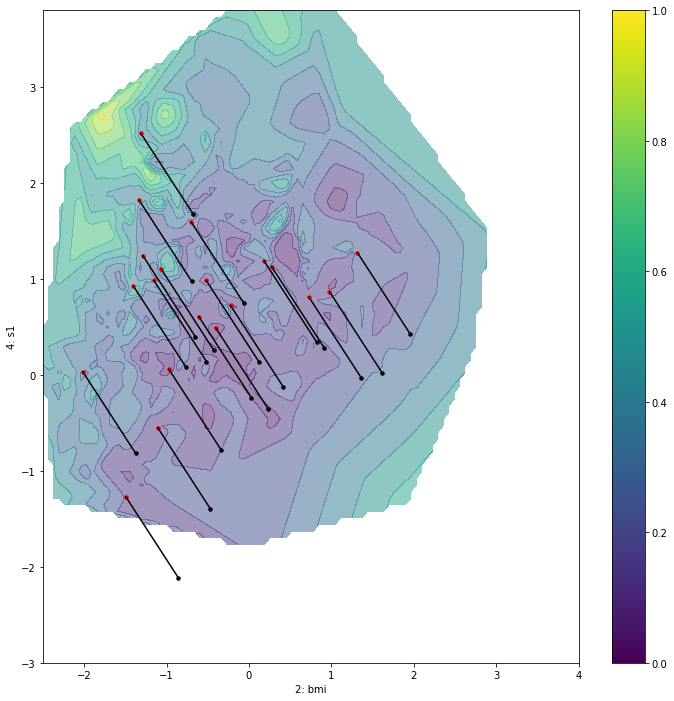

In [14]:
from scipy.interpolate import griddata
from scipy.ndimage.filters import gaussian_filter

feats = [2,4]
m_idx = -1

model = models[m_idx]
w_f = model.f.model.linear.weight.detach().numpy().squeeze()

cqr_model = cqr_models[m_idx]
w_f_cqr = cqr_model.f.model.linear.weight.detach().numpy().squeeze()


ngridx = 100
ngridy = 100
x1i = np.linspace(-2.5, 4, ngridx)
x2i = np.linspace(-3, 3.8, ngridy)

xp = model.move_points(x,eta,mask)
xp_trn, xp_tst = xp[idx_trn,:], xp[idx_tst,:]
xp1 = xp[:,feats[0]]
xp2 = xp[:,feats[1]]
lb, ub = model.u.predict(xp)
sz = ub-lb

# plt.scatter(x1,sz)
# plt.scatter(x2,sz)
# plt.show()

szi = griddata((xp1, xp2), sz, (x1i[None,:], x2i[:,None]), method='linear')
# szi = gaussian_filter(szi, 0.7)

n_ = 20
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.contourf(x1i, x2i, szi, levels=10, alpha=0.5) #, linewidths=0.5, colors='k')
for i in range(n_):
    plt.plot([x_tst[i,feats[0]],xp_tst[i,feats[0]]],[x_tst[i,feats[1]],xp_tst[i,feats[1]]],'k')

plt.scatter(x_tst[:n_,feats[0]], x_tst[:n_,feats[1]], color='k', s=12) #,markerfacecolor=None)
plt.scatter(xp_tst[:n_,feats[0]], xp_tst[:n_,feats[1]], color='r', s=12) #,markerfacecolor=None)
plt.colorbar()
plt.xlabel(titles_idx[feats[0]])
plt.ylabel(titles_idx[feats[1]])
plt.show()

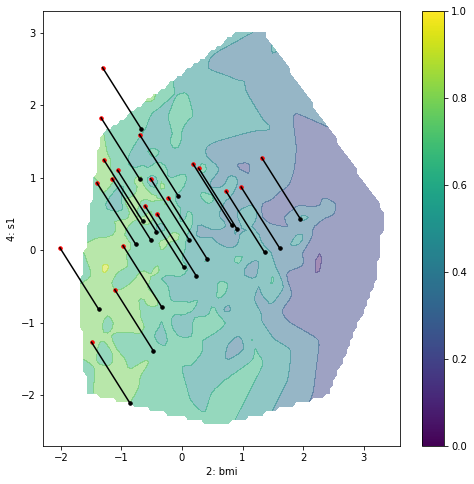

In [15]:
from scipy.interpolate import griddata
from scipy.ndimage.filters import gaussian_filter

feats = [2,4]

ngridx = 100
ngridy = 100
x1i = np.linspace(-1.9, 3.6, ngridx)
x2i = np.linspace(-2.7, 3.3, ngridy)

x1 = x[:,feats[0]]
x2 = x[:,feats[1]]

yi = griddata((x1, x2), y, (x1i[None,:], x2i[:,None]), method='linear')
yi = gaussian_filter(yi, 0.7)

n_ = 20
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.contourf(x1i, x2i, yi, levels=5, alpha=0.5) #, linewidths=0.5, colors='k')
for i in range(n_):
    plt.plot([x_tst[i,feats[0]],xp_tst[i,feats[0]]],[x_tst[i,feats[1]],xp_tst[i,feats[1]]],'k')

plt.scatter(x_tst[:n_,feats[0]], x_tst[:n_,feats[1]], color='k', s=12) #,markerfacecolor=None)
plt.scatter(xp_tst[:n_,feats[0]], xp_tst[:n_,feats[1]], color='r', s=12) #,markerfacecolor=None)
plt.colorbar()
plt.xlabel(titles_idx[feats[0]])
plt.ylabel(titles_idx[feats[1]])
plt.show()

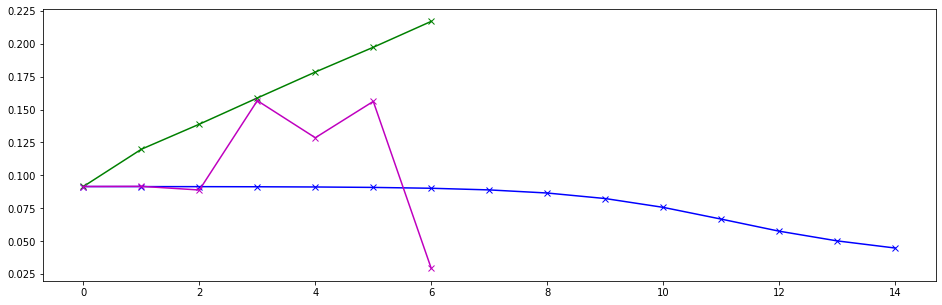

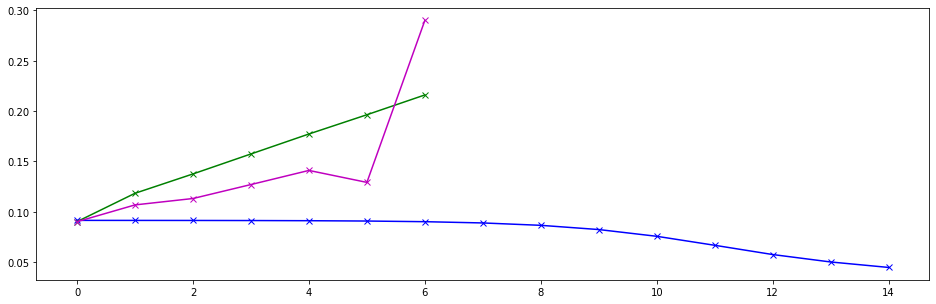

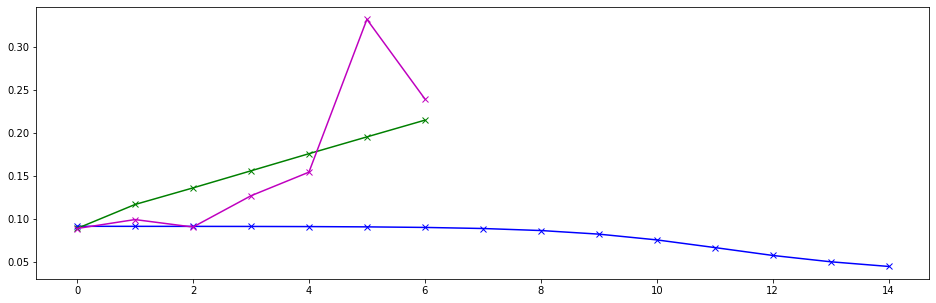

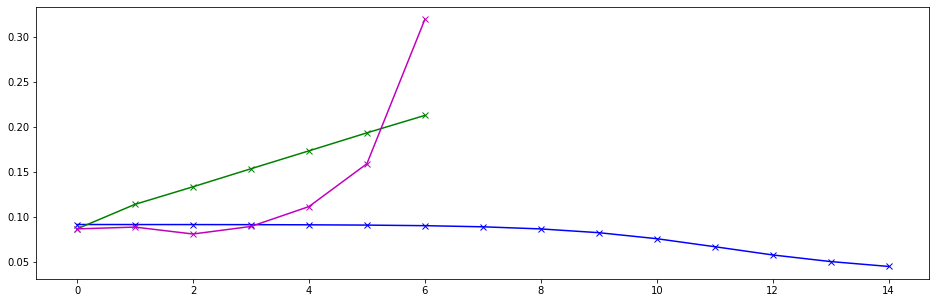

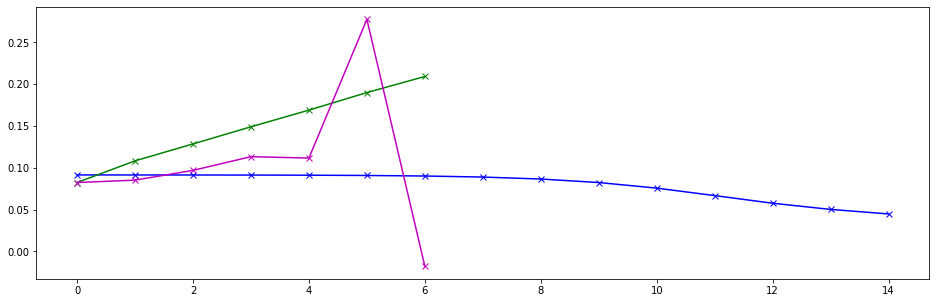

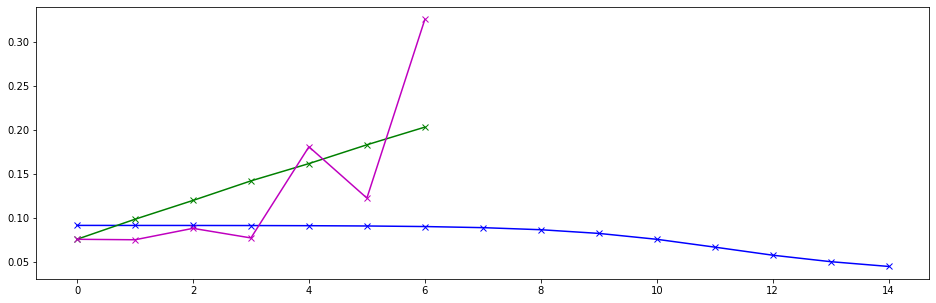

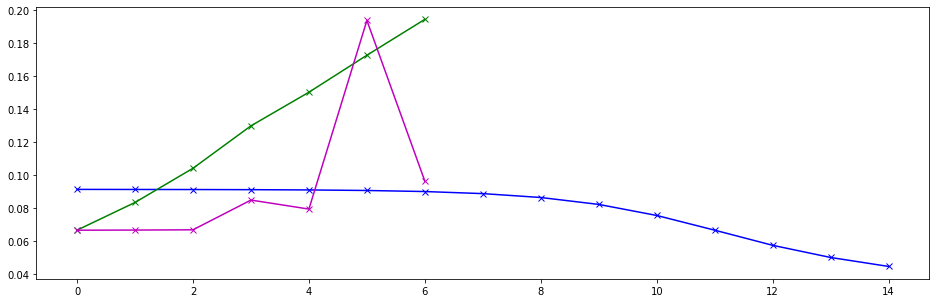

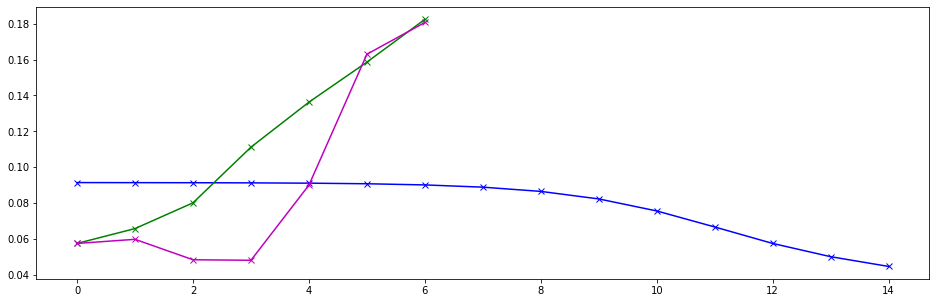

In [23]:
for i in range(len(all_perf_la)):
    plt.figure()
    plt.plot(perf_base['improve'][:,1],'-x', c='b')
    plt.plot(all_perf_la[i]['improve'][:,1],'-x', c='g')
    plt.plot(all_cqr_perf_la[i]['improve'][:,1],'-x', c='m')

seed: 1 , eta: 5.0


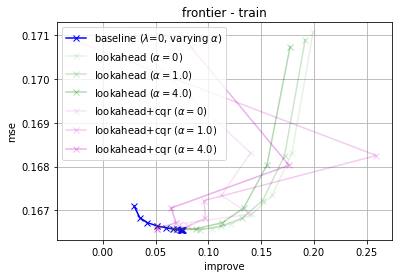

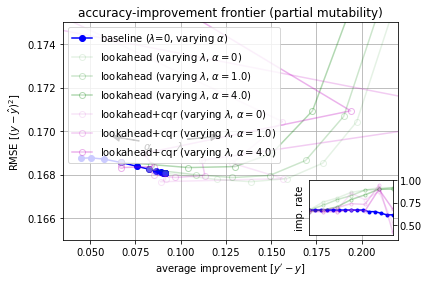

In [31]:
# plot
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

SAVE_FIG = False
fname = 'diabetes_mask_2-4_v2'

plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', plt.cm.tab20(np.arange(0,22,2)))
alphas_idx = [0, 4, -2]

print('seed:',seed,', eta:',eta)
plt.plot(perf_base['improve'][:,0], np.sqrt(perf_base['mse'][:,0]),'b-x')
for ind, i in enumerate(alphas_idx):
    plt.plot(all_perf_la[i]['improve'][:,0], np.sqrt(all_perf_la[i]['mse'][:,0]),'g-x', alpha=(0.1*(ind+1)),)

for ind, i in enumerate(alphas_idx):
    plt.plot(all_cqr_perf_la[i]['improve'][:,0], np.sqrt(all_perf_la[i]['mse'][:,0]),'m-x',alpha=(0.1*(ind+1)),)

# plt.plot(perf_naive['improve'][:,0], perf_naive['mse'][:,0],'g-x')
plt.title('frontier - train')
plt.ylabel('mse')
plt.xlabel('improve')
plt.legend(
    [
        r'baseline ($\lambda$=0, varying $\alpha$)',
        *[r'lookahead ($\alpha={}$)'.format(alphas_sub[i]) for i in alphas_idx],
        *[r'lookahead+cqr ($\alpha={}$)'.format(alphas_sub[i]) for i in alphas_idx],
    ],
    loc='upper left',
)
plt.grid()
# plt.ylim([0.,0.18])
plt.show()


plt.plot(perf_base['improve'][:,1], np.sqrt(perf_base['mse'][:,1]),'-o',c='b', markerfacecolor=None)
for ind, i in enumerate(alphas_idx):
    plt.plot(all_perf_la[i]['improve'][:,1], np.sqrt(all_perf_la[i]['mse'][:,1]),'-o',c='g', alpha=(0.1*(ind+1)), markerfacecolor='white')

for ind, i in enumerate(alphas_idx):
    plt.plot(all_cqr_perf_la[i]['improve'][:,1], np.sqrt(all_perf_la[i]['mse'][:,1]),'-o',c='m', alpha=(0.1*(ind+1)),markerfacecolor='white')

# plt.plot(perf_naive['improve'][:,1], perf_naive['mse'][:,1],'g-x')
plt.title('accuracy-improvement frontier (partial mutability)')
plt.ylabel('RMSE [$(y-\hat{y})^2$]')
plt.xlabel('average improvement [$y\'-y$]')
plt.legend(
    [
        r'baseline ($\lambda$=0, varying $\alpha$)',
        *[r'lookahead (varying $\lambda$, $\alpha={}$)'.format(alphas_sub[i]) for i in alphas_idx],
        *[r'lookahead+cqr (varying $\lambda$, $\alpha={}$)'.format(alphas_sub[i]) for i in alphas_idx],
    ],
    loc='upper left',
)
plt.grid()
plt.ylim([0.165, 0.175])
plt.xlim([0.035,0.22])

xx = perf_base['improve'][0,1]
yy = np.sqrt(perf_base['mse'][0,1])
plt.annotate(r'$\alpha$',
ha = 'center', va = 'bottom',
xytext = (xx-0.01,yy+0.001),
xy = (xx-0.03, yy+0.0017),
arrowprops = { 'facecolor' : 'black', 'shrink' : 0.05 , 'width':0.5, 'headwidth':7, 'headlength':7},
fontsize=11)
plt.annotate(r'$\lambda$',
ha = 'center', va = 'bottom',
xytext = (xx+0.008,yy+0.001),
xy = (xx+0.03, yy+0.0017),
arrowprops = { 'facecolor' : 'black', 'shrink' : 0.05 , 'width':0.5, 'headwidth':7, 'headlength':7},
fontsize=11)

ax = plt.gca()
axins = inset_axes(ax, width="25%", height="25%", loc=4)
axins.plot(np.linspace(0,1,len(alphas)),perf_base['imprate'][:,1],'-o',c='b', markerfacecolor=None,markersize=3)
for ind, i in enumerate(alphas_idx):
    axins.plot(np.linspace(0,1,len(lams)),all_perf_la[i]['imprate'][:,1],'-o', c='g', alpha=(0.1*(ind+1)),markerfacecolor='white',markersize=3)

for ind, i in enumerate(alphas_idx):
    axins.plot(np.linspace(0,1,len(lams)),all_cqr_perf_la[i]['imprate'][:,1],'-o', c='m', alpha=(0.1*(ind+1)), markerfacecolor='white',markersize=3)

axins.set_xticks([])
axins.set_yticks([0.5,0.75, 1.0])
axins.yaxis.tick_right()
axins.set_xlim([0,1])
axins.set_ylabel('imp. rate')


plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', plt.cm.tab10(np.arange(10)))

if SAVE_FIG:
    plt.draw()
    plt.savefig(fname+'.eps', format='eps', bbox_inches='tight')
    plt.savefig(fname+'.png', format='png', dpi=300, bbox_inches='tight')
    print('saved ' + fname)
else:
    plt.show()

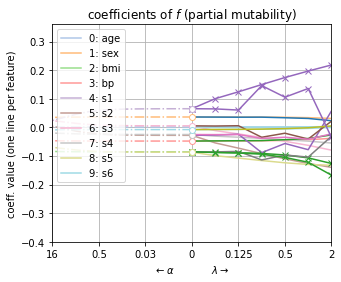

In [18]:
SAVE_FIG = False
# fname = 'wine_mask_ws'


models = all_models[0] #has alpha=0
cqr_models = all_cqr_models[0] #has alpha=0

ws_la_cqr = np.asarray([m.f.model.linear.weight.detach().numpy().squeeze() for m in cqr_models])
ws_la = np.asarray([m.f.model.linear.weight.detach().numpy().squeeze() for m in models])
ws_base = np.asarray([m.f.model.linear.weight.detach().numpy().squeeze() for m in models_base])

mask_idx = np.where(mask>0)[0]
non_mask_idx = np.setdiff1d(np.arange(d), mask_idx)

plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', plt.cm.tab20(np.arange(1,22,2)))
for i in range(d):
    if i not in list(mask_idx):
        plt.plot(np.arange(len(lams)),ws_la[:,i],'-') #,alpha=a)

    else:
        plt.plot([],[])

plt.gca().set_prop_cycle(cycler.cycler('color', plt.cm.tab20(np.arange(0,22,2))))
for i in range(d):
    if i in list(mask_idx):
        plt.plot(np.arange(len(lams)),ws_la[:,i],'-x') #,alpha=a)

    else:
        plt.plot([],[])

for i in range(d):
    if i not in list(mask_idx):
        plt.plot(np.arange(len(lams)),ws_la_cqr[:,i],'-') #,alpha=a)

    else:
        plt.plot([],[])

plt.gca().set_prop_cycle(cycler.cycler('color', plt.cm.tab20(np.arange(0,22,2))))
for i in range(d):
    if i in list(mask_idx):
        plt.plot(np.arange(len(lams)),ws_la_cqr[:,i],'-x') #,alpha=a)

    else:
        plt.plot([],[])

plt.gca().set_prop_cycle(cycler.cycler('color', plt.cm.tab20(np.arange(1,22,2))))
plt.plot(np.arange(0,-len(alphas),-1)/2,ws_base,'-.') #alpha=0.5)

plt.gca().set_prop_cycle(None)
for i in range(len(w_bench)):
    plt.plot(0,ws_base[0,i],'o',markerfacecolor='white')

plt.grid()
plt.ylim([-0.4,0.36])
plt.xlim([-6,6])
plt.title('coefficients of $f$ (partial mutability)')
plt.ylabel('coeff. value (one line per feature)')
plt.xlabel(r'$\leftarrow \alpha \qquad \qquad \lambda \rightarrow$')
plt.xticks([-6,-4,-2,0,2,4,6], [16,0.5,0.03,0,0.125,0.5,2])

custom_lines = [
    Line2D([0], [0], ls='-', marker='x', color='g', lw=1),
    Line2D([0], [0], ls='-', color='g', lw=1),
    Line2D([0], [0], ls='-', marker='o', color='b', lw=1),
    Line2D([0], [0], ls='-', color='b', lw=1),
    Line2D([0], [0], ls='-.', color='k', lw=1),
]

plt.legend(
    custom_lines,
    [
        'lookahead (mutable)',
        'lookahead (immutable)',
        'lookahead+cqr (mutable)',
        'lookahead+cqr (immutable)',
        'baseline',
    ],
    loc='upper left',
    fontsize=9.5)
plt.legend(titles_idx)

if SAVE_FIG:
    plt.draw()
    plt.savefig(fname+'.eps', format='eps', bbox_inches='tight')
    plt.savefig(fname+'.png', format='png', dpi=300, bbox_inches='tight')
    print('saved ' + fname)
else:
    plt.show()

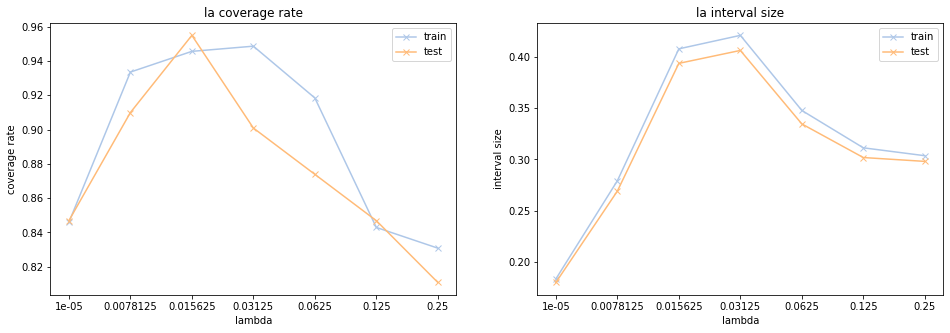

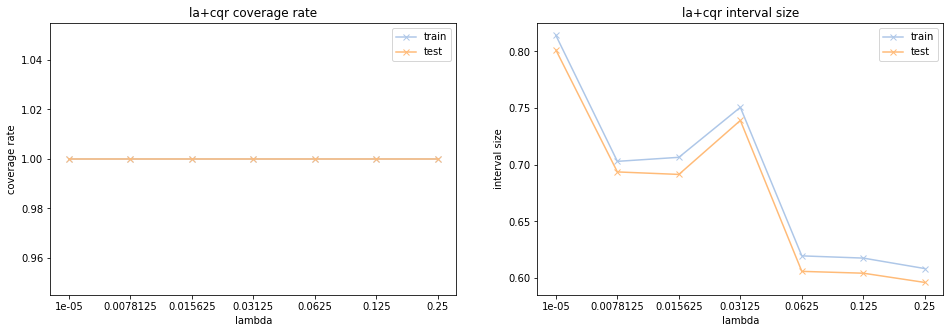

In [19]:
plt.rcParams['figure.figsize'] = (16.0, 5.0)

plt.subplot(121)
plt.plot(np.arange(len(lams)), perf_la['contain'][:,:2],'x-')
plt.title('la coverage rate')
plt.ylabel('coverage rate')
plt.xlabel('lambda')
plt.xticks(np.arange(len(lams)),lams)
plt.legend(['train','test'])

plt.subplot(122)
plt.plot(np.arange(len(lams)), perf_la['size'][:,:2],'x-')
plt.title('la interval size')
plt.ylabel('interval size')
plt.xlabel('lambda')
plt.xticks(np.arange(len(lams)),lams)
plt.legend(['train','test'])
plt.show()

plt.subplot(121)
plt.plot(np.arange(len(lams)), perf_cqr_la['contain'][:,:2],'x-')
plt.title('la+cqr coverage rate')
plt.ylabel('coverage rate')
plt.xlabel('lambda')
plt.xticks(np.arange(len(lams)),lams)
plt.legend(['train','test'])

plt.subplot(122)
plt.plot(np.arange(len(lams)), perf_cqr_la['size'][:,:2],'x-')
plt.title('la+cqr interval size')
plt.ylabel('interval size')
plt.xlabel('lambda')
plt.xticks(np.arange(len(lams)),lams)
plt.legend(['train','test'])
plt.show()